## **Membuat Model Regression dan Clustering**

**Tujuan**

- Mengetahui perkiraan quantity product yang terjual sehingga tim inventory dapat membuat stock persediaan harian yang cukup.
- Membuat cluster atau segmentasi customer.

**Library**

In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot

import warnings
warnings.filterwarnings('ignore')


### **1. Load Data**

In [61]:
df_customer = pd.read_csv('Customer.csv', index_col=0, sep=";").reset_index()
df_customer.head()

,CustomerID,Age,Gender,Marital Status,Income
0,1,55,1,Married,"5,12"
1,2,60,1,Married,"6,23"
2,3,32,1,Married,"9,17"
3,4,31,1,Married,"4,87"
4,5,58,1,Married,"3,57"


In [62]:
df_product = pd.read_csv('Product.csv', index_col=0, sep=";").reset_index()
df_product.head()

,ProductID,Product Name,Price
0,P1,Choco Bar,8800
1,P2,Ginger Candy,3200
2,P3,Crackers,7500
3,P4,Potato Chip,12000
4,P5,Thai Tea,4200


In [63]:
df_store = pd.read_csv('Store.csv', index_col=0, sep=";").reset_index()
df_store.head()

,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
0,1,Prima Tendean,Prima,Modern Trade,"-6,2","106,816666"
1,2,Prima Kelapa Dua,Prima,Modern Trade,"-6,914864","107,608238"
2,3,Prima Kota,Prima,Modern Trade,"-7,797068","110,370529"
3,4,Gita Ginara,Gita,General Trade,"-6,966667","110,416664"
4,5,Bonafid,Gita,General Trade,"-7,250445","112,768845"


In [64]:
df_transaction = pd.read_csv('Transaction.csv', index_col=0, sep=";").reset_index()
df_transaction.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
0,TR11369,328,01/01/2022,P3,7500,4,30000,12
1,TR16356,165,01/01/2022,P9,10000,7,70000,1
2,TR1984,183,01/01/2022,P1,8800,4,35200,4
3,TR35256,160,01/01/2022,P1,8800,7,61600,4
4,TR41231,386,01/01/2022,P9,10000,1,10000,4


### **2. Data Cleansing**

In [65]:
# df customer
df_customer['Income'] = df_customer['Income'].replace('[,]','.',regex=True).astype('float')

In [66]:
# df store
df_store['Latitude'] = df_store['Latitude'].replace('[,]', '.', regex=True).astype('float')
df_store['Longitude'] = df_store['Longitude'].replace('[,]', '.', regex=True).astype('float')

In [67]:
# df transaction
df_transaction['Date'] = pd.to_datetime(df_transaction['Date'], format='%d/%m/%Y')

### **3. Data Merge**

In [68]:
df_merge = pd.merge(df_transaction, df_customer, on=['CustomerID'])
df_merge = pd.merge(df_merge, df_product.drop(columns=['Price']), on=['ProductID'])
df_merge = pd.merge(df_merge, df_store, on=['StoreID'])

In [69]:
df_merge.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,Product Name,StoreName,GroupStore,Type,Latitude,Longitude
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,0,Married,10.53,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
1,TR89318,183,2022-07-17,P3,7500,1,7500,12,27,1,Single,0.18,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
2,TR9106,123,2022-09-26,P3,7500,4,30000,12,34,0,Married,4.36,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
3,TR4331,335,2022-01-08,P3,7500,3,22500,12,29,1,Single,4.74,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
4,TR6445,181,2022-01-10,P3,7500,4,30000,12,33,1,Married,9.94,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554


In [70]:
df_merge.isna().sum()

TransactionID      0
CustomerID         0
Date               0
ProductID          0
Price              0
Qty                0
TotalAmount        0
StoreID            0
Age                0
Gender             0
Marital Status    44
Income             0
Product Name       0
StoreName          0
GroupStore         0
Type               0
Latitude           0
Longitude          0
dtype: int64

In [71]:
df_merge.dropna(inplace = True)
df_merge.isna().sum()

TransactionID     0
CustomerID        0
Date              0
ProductID         0
Price             0
Qty               0
TotalAmount       0
StoreID           0
Age               0
Gender            0
Marital Status    0
Income            0
Product Name      0
StoreName         0
GroupStore        0
Type              0
Latitude          0
Longitude         0
dtype: int64

In [72]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4976 entries, 0 to 5019
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   TransactionID   4976 non-null   object        
 1   CustomerID      4976 non-null   int64         
 2   Date            4976 non-null   datetime64[ns]
 3   ProductID       4976 non-null   object        
 4   Price           4976 non-null   int64         
 5   Qty             4976 non-null   int64         
 6   TotalAmount     4976 non-null   int64         
 7   StoreID         4976 non-null   int64         
 8   Age             4976 non-null   int64         
 9   Gender          4976 non-null   int64         
 10  Marital Status  4976 non-null   object        
 11  Income          4976 non-null   float64       
 12  Product Name    4976 non-null   object        
 13  StoreName       4976 non-null   object        
 14  GroupStore      4976 non-null   object        
 15  Type     

### **4. Membuat Dataframe Regresi**

In [73]:
df_regresi = df_merge.groupby(['Date']).agg({'Qty' : 'sum'}).reset_index()

In [74]:
df_regresi.head()

,Date,Qty
0,2022-01-01,49
1,2022-01-02,59
2,2022-01-03,63
3,2022-01-04,45
4,2022-01-05,28


### **5. Machine Learning ARIMA**

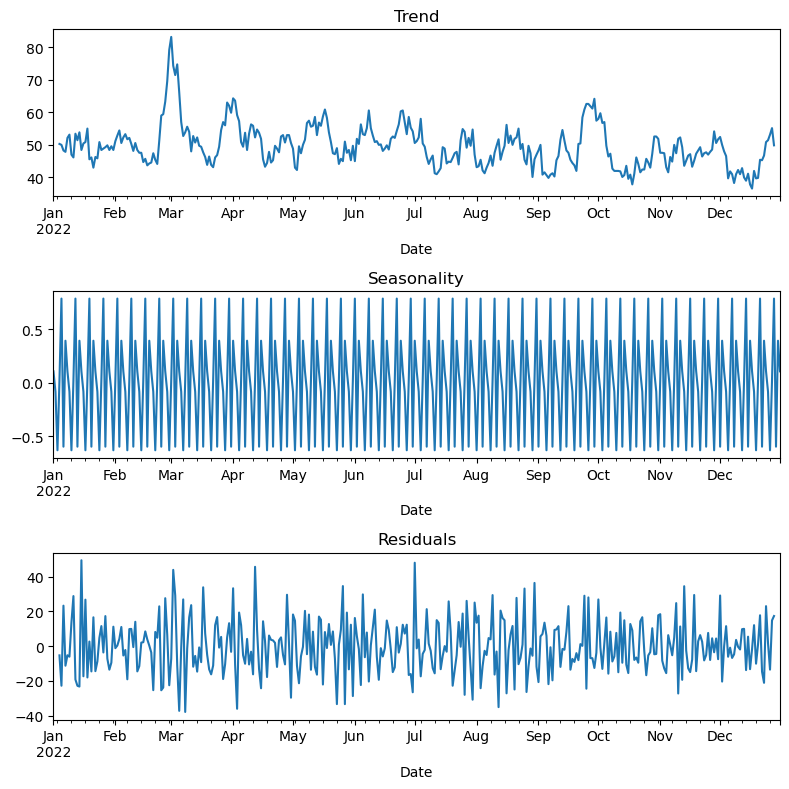

In [75]:
decomposed = seasonal_decompose(df_regresi.set_index('Date'))

plt.figure(figsize=(8, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()


In [76]:
cut_off = round(df_regresi.shape[0] * 0.9)
df_train = df_regresi[:cut_off]
df_test = df_regresi[cut_off:].reset_index(drop=True)
df_train.shape, df_test.shape

((328, 2), (37, 2))

In [77]:
df_train.head()

,Date,Qty
0,2022-01-01,49
1,2022-01-02,59
2,2022-01-03,63
3,2022-01-04,45
4,2022-01-05,28


In [78]:
df_test.head()

,Date,Qty
0,2022-11-25,55
1,2022-11-26,40
2,2022-11-27,53
3,2022-11-28,50
4,2022-11-29,55


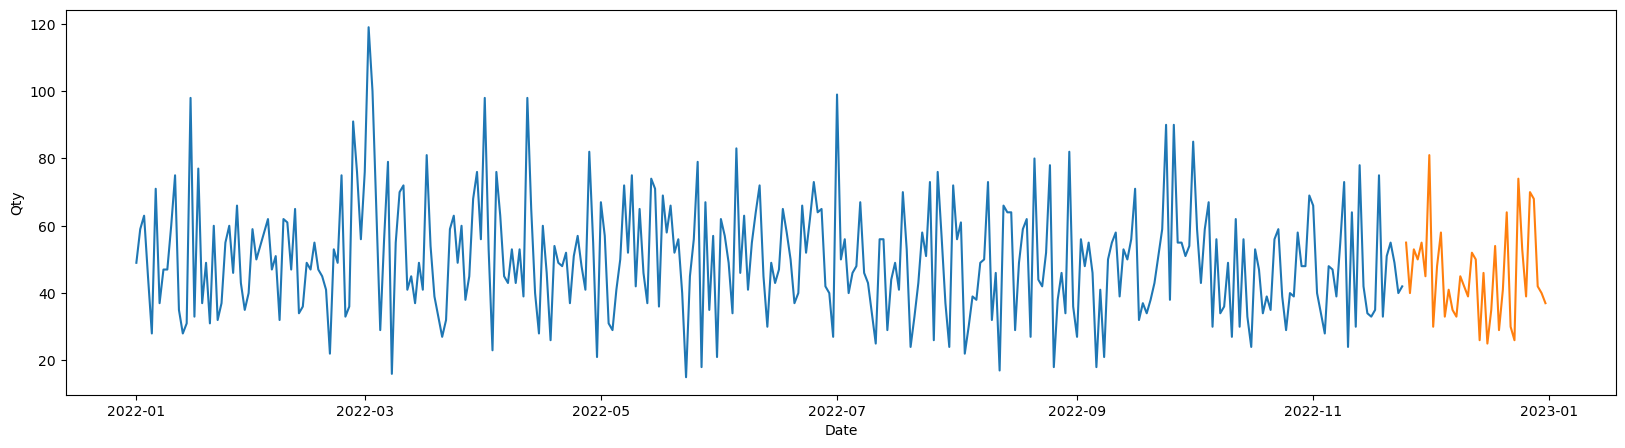

In [79]:
plt.figure(figsize=(20,5))
sns.lineplot(data=df_train, x=df_train['Date'], y=df_train['Qty']);
sns.lineplot(data=df_test, x=df_test['Date'], y=df_test['Qty']);

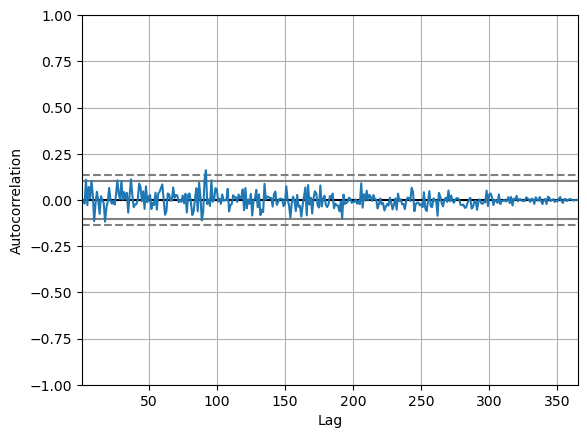

In [80]:
autocorrelation_plot(df_regresi['Qty']);

In [81]:
# function to calculate RMSE
def rmse(y_actual, y_pred):
    print(f'RMSE value {mean_squared_error(y_actual, y_pred)**0.5}')
    
# function to eval machine learnig modelling
def eval(y_actual, y_pred):
    rmse(y_actual, y_pred)
    print(f'MAE value {mean_absolute_error(y_actual, y_pred)}')

RMSE value 14.33352849656624
MAE value 11.376596640882354


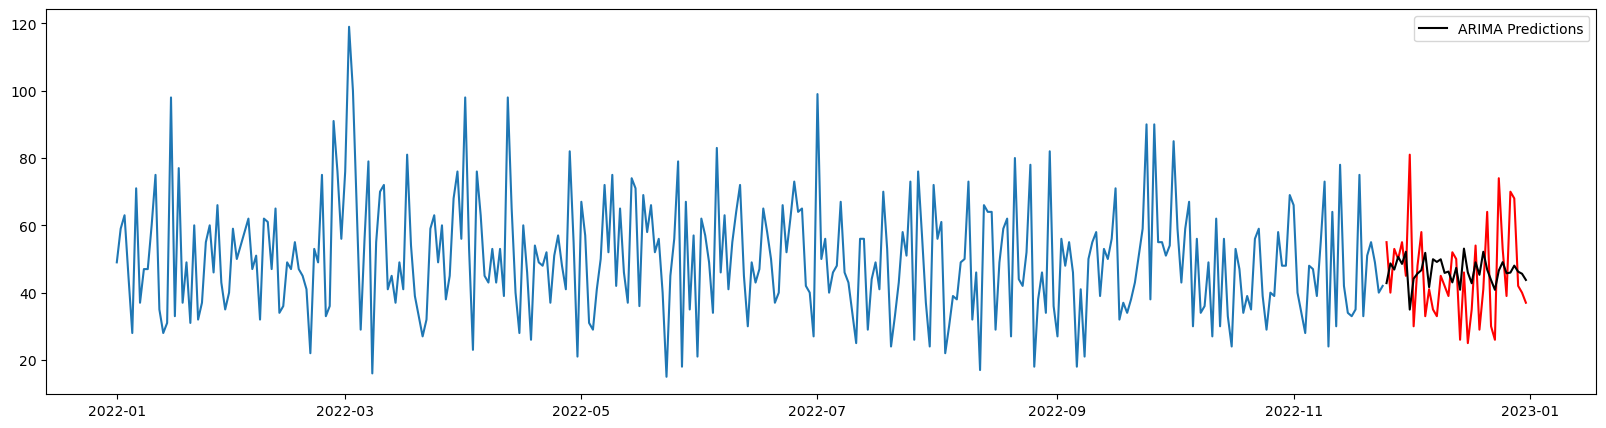

In [82]:
# ARIMA
df_train = df_train.set_index('Date')
df_test = df_test.set_index('Date')

y = df_train['Qty']

ARIMAmodel = ARIMA(y, order = (40, 2, 1))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(df_test))

y_pred_df = y_pred.conf_int()
y_pred_df['predictions'] = ARIMAmodel.predict(start =y_pred_df.index[0], end =y_pred_df.index[-1])
y_pred_df.index = df_test.index
y_pred_out = y_pred_df['predictions']
eval(df_test['Qty'], y_pred_out)

plt.figure(figsize=(20,5))
plt.plot(df_train['Qty'])
plt.plot(df_test['Qty'], color='red')
plt.plot(y_pred_out, color='black', label = 'ARIMA Predictions')
plt.legend()

### **6. Clustering**

In [83]:
df_merge.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,Product Name,StoreName,GroupStore,Type,Latitude,Longitude
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,0,Married,10.53,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
1,TR89318,183,2022-07-17,P3,7500,1,7500,12,27,1,Single,0.18,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
2,TR9106,123,2022-09-26,P3,7500,4,30000,12,34,0,Married,4.36,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
3,TR4331,335,2022-01-08,P3,7500,3,22500,12,29,1,Single,4.74,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
4,TR6445,181,2022-01-10,P3,7500,4,30000,12,33,1,Married,9.94,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554


In [84]:
df_cluster = df_merge.groupby(['CustomerID']).agg({
    'TransactionID' : 'count',
    'Qty' : 'sum',
    'TotalAmount' : 'sum'
}).reset_index()

In [85]:
df_cluster.head()

,CustomerID,TransactionID,Qty,TotalAmount
0,1,17,60,623300
1,2,13,57,392300
2,3,15,56,446200
3,4,10,46,302500
4,5,7,27,268600


In [86]:
data_cluster = df_cluster.drop(columns=['CustomerID'])

data_cluster_normalize = preprocessing.normalize(data_cluster)

data_cluster_normalize

array([[2.72741856e-05, 9.62618317e-05, 9.99999995e-01],
       [3.31379043e-05, 1.45296965e-04, 9.99999989e-01],
       [3.36172117e-05, 1.25504257e-04, 9.99999992e-01],
       ...,
       [3.06539507e-05, 1.15803814e-04, 9.99999993e-01],
       [2.59862980e-05, 9.92204105e-05, 9.99999995e-01],
       [2.95925334e-05, 9.56066465e-05, 9.99999995e-01]])

In [87]:
K = range(2, 8)
fits = []
score = []

for k in K:
    model = KMeans(n_clusters = k, random_state = 0, n_init='auto').fit(data_cluster_normalize)
    
    fits.append(model)
    
    score.append(silhouette_score(data_cluster_normalize, model.labels_, metric='euclidean'))

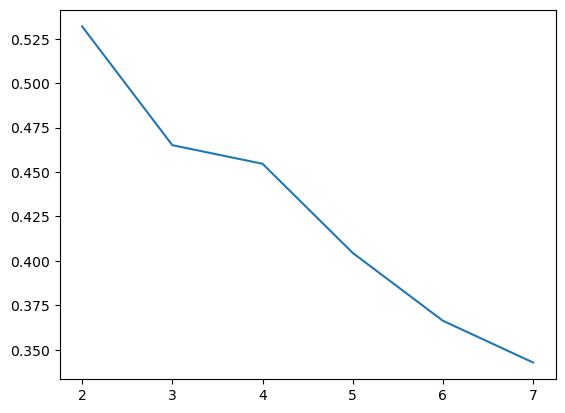

In [88]:
# choose 4 cluster
sns.lineplot(x = K, y =score);

K terbaik untuk model K-Means pada proyek ini adalah 4 (K = 4), artinya pelanggan akan dibagi menjadi 4 cluster.

In [89]:
df_cluster['cluster_label'] = fits[2].labels_

In [90]:
df_cluster.groupby(['cluster_label']).agg({
    'CustomerID' : 'count',
    'TransactionID' : 'mean',
    'Qty' : 'mean',
    'TotalAmount' : 'mean'
})

,CustomerID,TransactionID,Qty,TotalAmount
cluster_label,,,,
0,165,11.066667,41.551515,346976.363636
1,194,11.587629,40.613402,409496.391753
2,81,10.777778,40.395062,287344.444444
3,4,7.250000,29.500000,150100.000000


**Cluster 1**
- Cluster dengan jumlah pelanggan terbanyak.
- Rekomendasi: membangun hubungan baik dengan pelanggan dan melakukan survei untuk mengembangkan minat pelanggan.

**Cluster 0**
- Cluster dengan jumlah tertinggi kedua terbanyak.
- Rekomendasi: memberikan promosi berkala untuk meningkatkan transaksi dan melakukan upselling produk dengan harga tinggi.

**Cluster 2**
- Cluster dengan jumlah pelanggan sedikit.
- Rekomendasi: memberikan diskon yang signifikan untuk meningkatkan transaksi pelanggan, menawarkan promosi pada transaksi dengan kuantitas lebih tinggi, dan melakukan survei untuk mengidentifikasi potensi pengembangan produk.

**Cluster 3**
- Cluster dengan jumlah pelanggan paling sedikit.
- Menawarkan promosi loyalitas untuk mempertahankan transaksi, melakukan survei kepuasan pelanggan, dan melakukan upselling produk dengan harga lebih tinggi.